# Gemma cup detection V2

## Import

In [1]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.tensorboard import SummaryWriter

from skimage import io as sk_io

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils
import engine

import ipywidgets as widgets
from IPython.display import Image as IpImage
from IPython.display import display
from ipywidgets import HBox

from loaders import (
    GemmaDataset, 
    get_train_transform, 
    get_valid_transform, 
    Averager, 
)

%matplotlib inline

## Define Constants

In [2]:
data_path = os.path.join("..", "data_in")
images_path =os.path.join(data_path, "images")

test_index = 1

## Datasets

### Tests

#### Build test dataset

In [3]:
ds = GemmaDataset(
    csv=pd.read_csv(os.path.join(data_path, "boxes_final.csv")),
    images_path=images_path,
)
len(ds)

3767

#### Test boxes

In [4]:
len(ds.load_boxes(0))

2

In [5]:
ds.load_boxes(test_index)

(11,
 array([[631.53399658, 605.43951416, 669.23931885, 642.22845459],
        [899.24151611, 891.42657471, 936.94677734, 926.57598877],
        [699.29949951, 552.85705566, 739.0223999 , 591.03417969],
        [804.58917236, 852.86560059, 884.03497314, 924.50311279],
        [588.1729126 , 806.08197021, 657.92767334, 871.56750488],
        [840.01861572, 959.42999268, 886.85852051, 993.87109375],
        [625.36279297, 900.19134521, 698.74938965, 967.69586182],
        [688.91815186, 620.81872559, 761.61076504, 695.78479004],
        [852.00082397, 652.19805908, 914.58917236, 728.26046753],
        [914.32354736, 613.45507812, 946.37310791, 653.81768799],
        [939.84625244, 695.87548828, 964.86911011, 724.15185547]]))

In [6]:
ds.load_boxes(test_index)[0:1]

(11,)

#### Test images

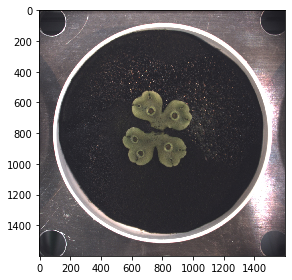

In [7]:
img = ds.load_image(test_index)
sk_io.imshow(img) 
sk_io.show()

#### Test sample

In [8]:
ds.get_by_sample_name("b0KXwBrE57rCtnxjL2jKk0AXGwCI.jpg")

(tensor([[[0.1647, 0.1647, 0.1647,  ..., 0.0941, 0.0941, 0.0941],
          [0.1647, 0.1647, 0.1647,  ..., 0.0941, 0.0941, 0.0941],
          [0.1725, 0.1725, 0.1725,  ..., 0.0941, 0.0941, 0.0941],
          ...,
          [0.2627, 0.2745, 0.2863,  ..., 0.1137, 0.1137, 0.1137],
          [0.2627, 0.2627, 0.2706,  ..., 0.1137, 0.1137, 0.1137],
          [0.2549, 0.2627, 0.2588,  ..., 0.1137, 0.1137, 0.1137]],
 
         [[0.1608, 0.1608, 0.1608,  ..., 0.0941, 0.0941, 0.0941],
          [0.1608, 0.1608, 0.1608,  ..., 0.0941, 0.0941, 0.0941],
          [0.1647, 0.1647, 0.1647,  ..., 0.0941, 0.0941, 0.0941],
          ...,
          [0.2549, 0.2667, 0.2784,  ..., 0.1059, 0.1059, 0.1059],
          [0.2431, 0.2549, 0.2627,  ..., 0.1059, 0.1059, 0.1059],
          [0.2353, 0.2431, 0.2510,  ..., 0.1059, 0.1059, 0.1059]],
 
         [[0.1804, 0.1804, 0.1804,  ..., 0.1020, 0.1020, 0.1020],
          [0.1804, 0.1804, 0.1804,  ..., 0.1020, 0.1020, 0.1020],
          [0.1843, 0.1843, 0.1843,  ...,

In [9]:
dd_sample = widgets.Dropdown(options=sorted(ds.images))

image_output = widgets.Output(layout={"border": "1px solid black"})
rects_output = widgets.Output(layout={"border": "1px solid black"})


def print_final_rects(change):
    image_output.clear_output()
    rects_output.clear_output()
    
    image, targets, _ = ds.get_by_sample_name(change.new)
                             
    boxes = targets['boxes'].cpu().numpy().astype(np.int32)
    image = image.permute(1,2,0).cpu().numpy()

    with image_output:
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        ax.set_axis_off()
        for box in boxes:
            ax.add_patch(
                patches.Rectangle(
                    (box[0], box[1]), 
                    box[2] - box[0], 
                    box[3] - box[1],
                    linewidth=2, 
                    edgecolor="r", 
                    facecolor="none",
                )
            )
        ax.imshow(image)
        plt.show()
    
    with rects_output:
        display(
            pd.DataFrame(
                [box for box in boxes], 
                columns=["x1", "y1", "x2", "y2"],                
            )
        )


dd_sample.observe(print_final_rects, names="value")
display(dd_sample, HBox([image_output, rects_output]))

Dropdown(options=('b-1HoJ-Hqz5STrwrZHGBYdjAE3Q.jpg', 'b-38OOnRNVd8OdKdmNYZXXy83E.jpg', 'b-3Q-HdqeuB2sRxMIzzUPN…

## Create model

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [11]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Build data loaders

### Create train and test dataframes

#### Load and clean dataframe

In [12]:
df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "boxes.csv"))
df = df[(df.width != 0) & (df.height != 0)].reset_index()
df.head()

,index,filename,x,y,width,height
0,0,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,690.798218,560.637146,45.351654,39.815979
1,1,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,1004.213104,791.837433,43.049530,46.096863
2,2,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,611.747009,738.196106,91.825195,84.914490
3,3,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,905.668762,749.575195,79.746094,84.656433
4,4,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,708.588226,613.453003,94.325226,72.136810


In [13]:
df.size

1434

#### Split dataframe

In [14]:
sizes: tuple = (0.8, 0.20)
dataset_size = len(list(df.filename.unique()))
indices = [ i for i in list(df.filename.unique())]

split_train = int(np.floor(sizes[0] * dataset_size))
split_test = int(np.floor(sizes[1] * dataset_size)) + split_train

np.random.shuffle(indices)
train_indices, test_indices = (
    indices[:split_train],
    indices[split_train:split_test],
)

df_train = df[df.filename.isin(train_indices)]
df_test = df[df.filename.isin(test_indices)]

In [15]:
df_train.size

1116

In [16]:
df_test.size

318

In [17]:
df_train.drop_duplicates(subset=["filename"]).head()

,index,filename,x,y,width,height
0,0,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,690.798218,560.637146,45.351654,39.815979
10,10,b00s9swai4uy9RmDXcnkiY1PpZ2M.jpg,610.178619,555.672180,52.402435,47.337433
14,14,b0BBwUoWkQfXpAUn8gvPh0AJy1hQ.jpg,NaN,NaN,NaN,NaN
15,15,b0DaRvfMv4Ve9fQ7-vmzY5lXanY.jpg,NaN,NaN,NaN,NaN
16,16,b0Dkf149PgiY8uzDB1naeNyC0L9A.jpg,869.565491,847.176147,80.138489,65.199829


In [18]:
df_test.drop_duplicates(subset=["filename"]).head()

,index,filename,x,y,width,height
38,38,b0LLoYT8lOeGd8hpo6aLHmL-5pT4.jpg,843.925781,972.469086,82.392487,61.758026
88,88,b0QW0SprPZiHjZybnVj2TRmix-0.jpg,NaN,NaN,NaN,NaN
93,93,b0T2ebAT7KUKoVYpB4MpfQJe19Y.jpg,978.698242,732.395508,68.697083,58.174438
108,108,b0WqgQQy-xahew1Amsw3C5DhvLU.jpg,641.710358,677.762573,83.898743,65.471222
151,151,b0eoMSzlZJPq0j2QXfjPckJY1iuY.jpg,816.396118,527.746246,76.790955,60.038361


#### Look for leakage

In [19]:
# Look for leakage
pd.merge(
    df_train,
    df_test,
    on=list(df_test.columns),
    how="inner",
).head()

,index,filename,x,y,width,height


#### Ensure images are only in one set

In [20]:
set(df_train.filename.to_list()).intersection(set(df_test.filename.to_list()))

set()

### Build datasets

In [21]:
train_dataset = GemmaDataset(
    csv=df_train, 
    transform=get_train_transform(),
    images_path=images_path,
    get_item_with_index=False,
    
)
valid_dataset = GemmaDataset(
    csv=df_test,
    transform=get_valid_transform(),
    images_path=images_path,
    get_item_with_index=False,
)

In [22]:
# for i in range(len(train_dataset)):
#     train_dataset[i]

### Build loaders

In [23]:
batch_size = 5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [24]:
train_data_loader.dataset[0]

(tensor([[[0.1776, 0.1776, 0.1776,  ..., 0.2100, 0.2067, 0.2035],
          [0.1776, 0.1776, 0.1776,  ..., 0.2100, 0.2100, 0.2067],
          [0.1776, 0.1776, 0.1776,  ..., 0.2067, 0.2067, 0.2035],
          ...,
          [0.1841, 0.1841, 0.1841,  ..., 0.2164, 0.2132, 0.2132],
          [0.1776, 0.1809, 0.1809,  ..., 0.2164, 0.2132, 0.2100],
          [0.1744, 0.1776, 0.1809,  ..., 0.2164, 0.2132, 0.2100]],
 
         [[0.1712, 0.1712, 0.1712,  ..., 0.2035, 0.2003, 0.1970],
          [0.1712, 0.1712, 0.1712,  ..., 0.2035, 0.2035, 0.2003],
          [0.1712, 0.1712, 0.1712,  ..., 0.2035, 0.2035, 0.2003],
          ...,
          [0.1809, 0.1809, 0.1809,  ..., 0.2100, 0.2067, 0.2067],
          [0.1776, 0.1809, 0.1776,  ..., 0.2100, 0.2067, 0.2035],
          [0.1744, 0.1776, 0.1776,  ..., 0.2100, 0.2067, 0.2035]],
 
         [[0.1809, 0.1809, 0.1809,  ..., 0.2197, 0.2164, 0.2132],
          [0.1809, 0.1809, 0.1809,  ..., 0.2197, 0.2197, 0.2164],
          [0.1809, 0.1809, 0.1809,  ...,

## Sample

In [25]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [26]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
boxes

array([[ 690,  560,  736,  600],
       [1004,  791, 1047,  837],
       [ 611,  738,  703,  823],
       [ 905,  749,  985,  834],
       [ 708,  613,  802,  685],
       [ 886,  571,  941,  620],
       [ 960,  604, 1015,  664],
       [ 967,  839, 1015,  882],
       [ 761,  551,  801,  581],
       [ 869,  632,  952,  711]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


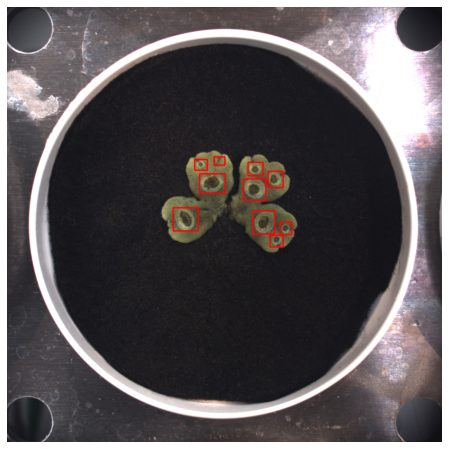

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(
        sample,
        (box[0], box[1]),
        (box[2], box[3]),
        (220, 0, 0), 
        3
    )

ax.set_axis_off()
ax.imshow(sample)

## Train

In [29]:
model.to(device)
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad], 
    lr=0.005, 
    momentum=0.9, 
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None

num_epochs = 200


for epoch in range(num_epochs):
    engine.train_one_epoch(
        model=model,
        optimizer=optimizer,
        data_loader=train_data_loader,
        device=device,
        epoch=epoch,
        print_freq=100,
    )
    lr_scheduler.step()
    engine.evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [0/8]  eta: 0:00:36  lr: 0.000719  loss: 1.5900 (1.5900)  loss_classifier: 0.6949 (0.6949)  loss_box_reg: 0.0913 (0.0913)  loss_objectness: 0.7653 (0.7653)  loss_rpn_box_reg: 0.0385 (0.0385)  time: 4.5178  data: 0.6641  max mem: 3984
Epoch: [0]  [7/8]  eta: 0:00:01  lr: 0.005000  loss: 0.8843 (1.0114)  loss_classifier: 0.2997 (0.3868)  loss_box_reg: 0.1735 (0.2187)  loss_objectness: 0.2008 (0.3648)  loss_rpn_box_reg: 0.0306 (0.0410)  time: 1.2394  data: 0.4770  max mem: 4249
Epoch: [0] Total time: 0:00:09 (1.2396 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.1451 (0.1451)  evaluator_time: 0.0391 (0.0391)  time: 0.3989  data: 0.1988  max mem: 4249
Test:  [1/2]  eta: 0:00:00  model_time: 0.1451 (0.1453)  evaluator_time: 0.0391 (0.0404)  time: 0.4049  data: 0.2027  max mem: 4249
Test: Total time: 0:00:00 (0.4054 s / it)
Averaged stats: model_time: 0.1451 (0.1453)  evaluator_time: 0.0391 (0.0404)
Accumulating evaluation results...
DONE (t=0.

## Save state dict

In [34]:
state_output_path = os.path.join("..", "models",datetime.now().strftime("%Y%m%d-%H%M%S") + "state_dict.pth")

In [35]:
torch.save(
    model.state_dict(), 
    state_output_path
)

## Save model

In [36]:
model_output_path = os.path.join("..", "models",datetime.now().strftime("%Y%m%d-%H%M%S") + "model.pth")

In [37]:
torch.save(model, model_output_path)